In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mshr
import numpy as np
import scipy.integrate as integrate
from fenics import *
import pickle

# local imports
from modules.mesh_utils import get_mesh
from modules.physics_utils import get_VandE, compute_trajectory, coord_impact, intersection
#from modules.plotting_utils import ?

# Parametres

In [2]:
mesh_dict = { # we need L < L_mot
    'L_mot' : .005,
    'l_mot' : .003,
    'L_1' : .003, # dim_trou = L_mot-L = .002 ici
    'l_1': .001,
    'L_2' : .004, # dim_trou = .001 ici
    'l_2' : .002,
    'delta_vert_12' : .001,
    'L_vacuum' : .05,
    'l_vacuum': .02,
    'mesh_resolution' : 100,
    'refine_mesh' : True,
}

phi_dict = {
    'Phi_top_mot' : 0,
    'Phi_bord_mot': 'N',
    'Phi_electrode1' :30,
    'Phi_inter_electrode':'N',
    'Phi_electrode2':300,
    'Phi_sup_vacuum':'N',
    'Phi_inf_vacuum':'N',
}

physics_consts_dict = {
    'rhoelec': 0,
    'l_rho':0, #dist between rho and 0 // <l_2 // if 0, we consider rhoelec uniform
    'PERMITTIVITY' : 8.54e-12,
    'CHARGE':1.6e-19,
    'M_NUCLEON':1.7e-27,
}

integration_parameters_dict = { #Best ==> 'tmax' : .00002 and 'dt' : .00000001 and '%Nout':100
    'tmax' : .000007,
    'dt' : .00000005,
    '%Nout': 95,
}

injection_dict = {
    'Nombre de particules':1000,
    'proportion de I':0,
    'proportion de I+':0,
    'proportion de I-':1,
    'débit de particule en entrée de la grille':1e12,
    'gamma':1,  ####Change ici 
    'Vion':2000,
    'Vneutre':200,
    'Sigma_Vion':500,
    'Sigma_Vneutre':80,
}

mode_dict={
    'Choc symétrique?':False,
    'Contact inter particules?':False,
    'coef inelasticite':0.1, 
    'coef scattering':0.3,
    'proba perte q par choc':1, 
    'X0 fixe ?':False,
}

In [3]:
liste_couples=[[.003,0.001],
              [0.004,0.001],
              [0.003,0.01],
              [0.004,0.01]] #L_2,l_2

# Plot des géométries des cas test

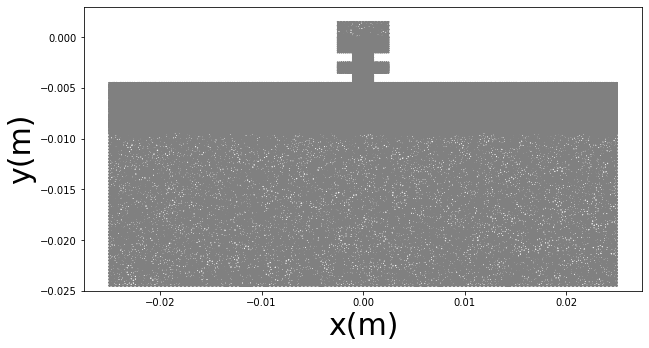

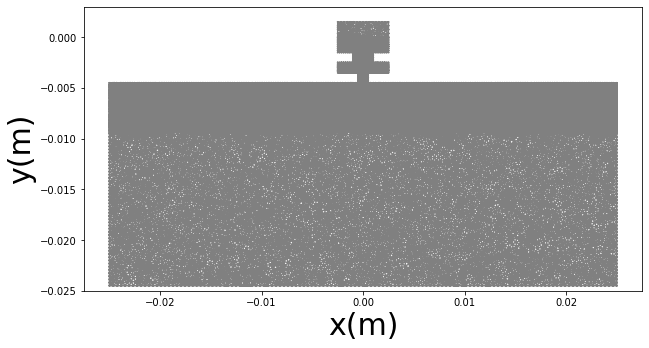

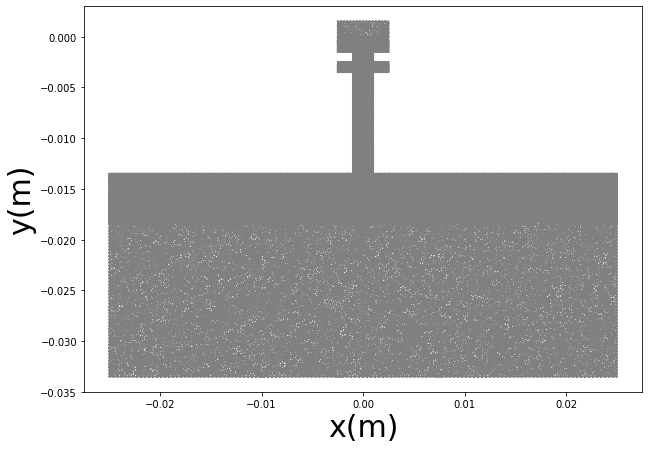

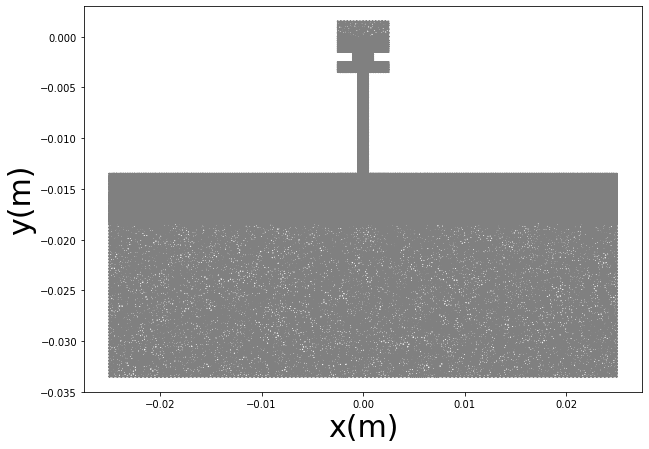

In [4]:
for couple in liste_couples: 
    mesh_dict['L_2']=couple[0]
    mesh_dict['l_2']=couple[1]
    mesh, segments_list, zone = get_mesh(mesh_dict)
    plt.figure(figsize=(10,10))
    if couple[1]==0.001:
        plt.ylim(-0.025,0.003)
    else:
        plt.ylim(-0.035,0.003)
    plot(mesh)
    plt.xlabel('x(m)', size=30)
    plt.ylabel('y(m)', size=30)
    plt.show()

# Maj des listes 

In [ ]:
with open("CAS_TEST_liste_param_testes.txt", "rb") as fp:
    liste_param_testes = pickle.load(fp)
with open("CAS_TEST_liste_Nb_out.txt", "rb") as fp:
    liste_Nb_out = pickle.load(fp)
with open("CAS_TEST_liste_pf.txt", "rb") as fp:
    liste_pf = pickle.load(fp)
with open("CAS_TEST_liste_alpha_moy.txt", "rb") as fp:
    liste_alpha_moy = pickle.load(fp)
with open("CAS_TEST_liste_alpha_sigma.txt", "rb") as fp:
    liste_alpha_sigma = pickle.load(fp)
with open("CAS_TEST_liste_V_moy.txt", "rb") as fp:
    liste_V_moy = pickle.load(fp)
with open("CAS_TEST_liste_V_sigma.txt", "rb") as fp:
    liste_V_sigma = pickle.load(fp)
with open("CAS_TEST_liste_param_testes_detail_gamma1.txt", "rb") as fp:
    liste_param_testes_detail_gamma1 = pickle.load(fp)
with open("CAS_TEST_liste_alpha_detail_gamma1.txt", "rb") as fp:
    liste_alpha_detail_gamma1 = pickle.load(fp)
with open("CAS_TEST_liste_V_detail_gamma1.txt", "rb") as fp:
    liste_V_detail_gamma1 = pickle.load(fp)

In [ ]:
'''liste_param_testes = []
liste_Nb_out=[]
liste_pf = []
liste_alpha_moy = []
liste_alpha_sigma = []
liste_V_moy = []
liste_V_sigma = []
liste_param_testes_detail_gamma1 = []
liste_alpha_detail_gamma1 = []
liste_V_detail_gamma1 = []''' 

In [ ]:
liste_gamma=[.01,1,10]
liste_couleur=['red']*4+['orange']*4+['yellow']*4
#liste_couples est déjà définie

# Pour chaque triplet [gamma, L_2, l_2], on crée le mesh puis on calcule E. 
# Ensuite on lance 1000 particules I-, on simule sans détail (avec si gamma=1) et on stocke les données finales.
 
for gamma in liste_gamma:
    for couple in liste_couples:
        
        param = [gamma,couple[0],couple[1]]
        
        if param in liste_param_testes:
            print('combinaison '+str(param)+' déjà testée')
            
        else:    
            injection_dict['gamma'] = gamma
            mesh_dict['L_2'] = couple[0]
            mesh_dict['l_2'] = couple[1]
            
            mesh, segments_list, zone = get_mesh(mesh_dict)
            Phi, E, f = get_VandE(mesh, mesh_dict, phi_dict, physics_consts_dict)
            
            if gamma == 1:
                Nb_out, pf_3_especes, alpha_moy_3_especes, alpha_sigma_3_especes, V_moy_3_especes, V_sigma_3_especes, \
                listes_x, listes_y, listes_vx, listes_vy, listes_q, liste_t, \
                liste_alpha1, liste_alpha2, liste_alpha3, liste_V1, liste_V2, liste_V3 = \
                compute_trajectory(integration_parameters_dict, injection_dict, mesh_dict, mode_dict, segments_list, zone, E, physics_consts_dict, True)
                
                liste_Nb_out.append(Nb_out)
                liste_pf.append(pf_3_especes)
                liste_alpha_moy.append(alpha_moy_3_especes)
                liste_alpha_sigma.append(alpha_sigma_3_especes)
                liste_V_moy.append(V_moy_3_especes)
                liste_V_sigma.append(V_sigma_3_especes)
                liste_param_testes.append(param)
                
                liste_param_testes_detail_gamma1.append(param)
                liste_alpha_detail_gamma1.append([liste_alpha1, liste_alpha2, liste_alpha3])
                liste_V_detail_gamma1.append([liste_V1, liste_V2, liste_V3])
                
            else:
                Nb_out, pf_3_especes, alpha_moy_3_especes, alpha_sigma_3_especes, V_moy_3_especes, V_sigma_3_especes = \
                compute_trajectory(integration_parameters_dict, injection_dict, mesh_dict, mode_dict, segments_list, zone,E, physics_consts_dict, False)

                liste_Nb_out.append(Nb_out)
                liste_pf.append(pf_3_especes)
                liste_alpha_moy.append(alpha_moy_3_especes)
                liste_alpha_sigma.append(alpha_sigma_3_especes)
                liste_V_moy.append(V_moy_3_especes)
                liste_V_sigma.append(V_sigma_3_especes)
                liste_param_testes.append(param)
            
            print('combinaison '+str(param)+' testée')
            print('------------------------------------------------------')
                           
            with open("CAS_TEST_liste_param_testes.txt", "wb") as fp:
                pickle.dump(liste_param_testes, fp)
            with open("CAS_TEST_liste_Nb_out.txt", "wb") as fp:
                pickle.dump(liste_Nb_out, fp)
            with open("CAS_TEST_liste_pf.txt", "wb") as fp:
                pickle.dump(liste_pf, fp)
            with open("CAS_TEST_liste_alpha_moy.txt", "wb") as fp:
                pickle.dump(liste_alpha_moy, fp)
            with open("CAS_TEST_liste_alpha_sigma.txt", "wb") as fp:
                pickle.dump(liste_alpha_sigma, fp)
            with open("CAS_TEST_liste_V_moy.txt", "wb") as fp:
                pickle.dump(liste_V_moy, fp)
            with open("CAS_TEST_liste_V_sigma.txt", "wb") as fp:
                pickle.dump(liste_V_sigma, fp)
            with open("CAS_TEST_liste_param_testes_detail_gamma1.txt", "wb") as fp:
                pickle.dump(liste_param_testes_detail_gamma1, fp)
            with open("CAS_TEST_liste_alpha_detail_gamma1.txt", "wb") as fp:
                pickle.dump(liste_alpha_detail_gamma1, fp)
            with open("CAS_TEST_liste_V_detail_gamma1.txt", "wb") as fp:
                pickle.dump(liste_V_detail_gamma1, fp)

In [ ]:
liste_param_testes = np.array(liste_param_testes)
liste_Nb_out = np.array(liste_Nb_out)
liste_pf = np.array(liste_pf)
liste_alpha_moy = np.array(liste_alpha_moy)
liste_alpha_sigma = np.array(liste_alpha_sigma)
liste_V_moy = np.array(liste_V_moy)
liste_V_sigma = np.array(liste_V_sigma)

liste_param_testes_detail_gamma1 = np.array(liste_param_testes_detail_gamma1)
liste_alpha_detail_gamma1 = np.array(liste_alpha_detail_gamma1)
liste_V_detail_gamma1 = np.array(liste_V_detail_gamma1)

# Extraction des cas gamma=1 des listes _moy et _sigma

In [ ]:
#les listes suivies de _gamma1 sont extraites des listes ci-dessus, mais uniquement les config à gamma=1
#sauf liste_param_testes_gamma1 inutile car c'est exactement liste_param_testes_detail_gamma1

liste_Nb_out_gamma1 = []
liste_pf_gamma1 = []
liste_alpha_moy_gamma1 = []
liste_alpha_sigma_gamma1 = []
liste_V_moy_gamma1 = []
liste_V_sigma_gamma1 = []

for i in range(len(liste_param_testes)):
    if liste_param_testes[i,0] == 1:
        liste_Nb_out_gamma1.append(liste_Nb_out[i])
        liste_pf_gamma1.append(liste_pf[i])
        liste_alpha_moy_gamma1.append(liste_alpha_moy[i])
        liste_alpha_sigma_gamma1.append(liste_alpha_sigma[i])
        liste_V_moy_gamma1.append(liste_V_moy[i])
        liste_V_sigma_gamma1.append(liste_V_sigma[i])

liste_Nb_out_gamma1 = np.array(liste_Nb_out_gamma1)
liste_pf_gamma1 = np.array(liste_pf_gamma1)
liste_alpha_moy_gamma1 = np.array(liste_alpha_moy_gamma1)
liste_alpha_sigma_gamma1 = np.array(liste_alpha_sigma_gamma1)
liste_V_moy_gamma1 = np.array(liste_V_moy_gamma1)
liste_V_sigma_gamma1 = np.array(liste_V_sigma_gamma1)

liste_token=['$1$','$2$','$3$','$4$']

# Plot

# N°1

In [ ]:
abscisse=[1,2,3,4]
ordonnee=[]

for i in range(len(liste_param_testes)):
    ordonnee.append(liste_pf[i][0])
   
plt.figure(figsize=(10,10))
plt.scatter(abscisse,ordonnee[:4],label='gamma=0',color='red')
plt.scatter(abscisse,ordonnee[4:8],label='gamma=1',color='orange')
plt.scatter(abscisse,ordonnee[8:12],label='gamma=inf',color='yellow')
plt.xlabel('N° du cas test', size=30)
plt.ylabel("taux de neutralisation en sortie",size=30)
plt.ylim(-0.01,1)
plt.xticks([1, 2, 3, 4])
plt.text(.9,-.2,'1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, \nchocs non symétriques, sans collision, rho=0', fontsize=15)
plt.text(.9,-.3, 'rouge => injection circulaire \njaune => injection plane', fontsize=15)
plt.show()

# N°2

In [22]:
abscisse=[1,2,3,4]
ordonnee=liste_pf_gamma1[:,0]

plt.figure(figsize=(10,10))
plt.scatter(abscisse, ordonnee, color='k')
plt.xlabel('N° du cas test', size=30)
plt.ylabel("taux de neutralisation en sortie",size=30)
plt.ylim(-0.01,1)
plt.xticks([1, 2, 3, 4])
plt.text(.9,-.2,'1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, \nchocs non symétriques, sans collision, rho=0, gamma=1', size=15)

plt.show()

[5, 6.5, -7, 3]

# N°3

In [ ]:
abscisse=[1,2,3,4]
ordonnee1=liste_alpha_moy_gamma1[:,0]
barre1=liste_alpha_sigma_gamma1[:,0]
barre1=1.96*barre1*np.power(liste_pf_gamma1[:,0]*liste_Nb_out_gamma1,-.5)
ordonnee2=liste_alpha_moy_gamma1[:,2]
barre2=liste_alpha_sigma_gamma1[:,2]
barre2=1.96*barre2*np.power(liste_pf_gamma1[:,2]*liste_Nb_out_gamma1,-.5)

plt.figure(figsize=(20,7))

ax = plt.subplot(1,2,1)
plt.scatter(abscisse, ordonnee1, color='k')
plt.errorbar(abscisse, ordonnee1, yerr=barre1, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
y_pi   = ordonnee1/np.pi
unit   = 0.05
y_tick = np.arange(-0.05, 0.051, unit)
y_label = [r"$-\frac{\pi}{20}$", r"$0$", r"$+\frac{\pi}{20}$"]
ax.set_yticks(y_tick*np.pi)
ax.set_yticklabels(y_label, fontsize=20)
plt.xlabel('N° du cas test', size=30)
plt.ylabel('angle (rad) du flux',size=30)
plt.ylim(-np.pi/15, np.pi/15)
plt.xticks([1, 2, 3, 4])
plt.title('I',size=30)

ax = plt.subplot(1,2,2)
plt.scatter(abscisse, ordonnee2, color='k')
plt.errorbar(abscisse, ordonnee2, yerr=barre2, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
y_pi   = ordonnee2/np.pi
unit   = 0.05
y_tick = np.arange(-0.05, 0.051, unit)
y_label = [r"$-\frac{\pi}{20}$", r"$0$", r"$+\frac{\pi}{20}$"]
ax.set_yticks(y_tick*np.pi)
ax.set_yticklabels(y_label, fontsize=20)
plt.xlabel('N° du cas test', size=30)
plt.ylabel("angle (rad) du flux",size=30)
plt.ylim(-np.pi/15, np.pi/15)
plt.xticks([1, 2, 3, 4])
plt.title('I-',size=30)

plt.text(-3,-.3,'1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, chocs non symétriques, sans collision, rho=0, gamma=1', size=15)

plt.show()

# N°4

In [ ]:
abscisse=[1,2,3,4]
ordonnee1=liste_V_moy_gamma1[:,0]
barre1=liste_V_sigma_gamma1[:,0]
barre1=1.96*barre1*np.power(liste_pf_gamma1[:,0]*liste_Nb_out_gamma1,-.5)
ordonnee2=liste_V_moy_gamma1[:,2]
barre2=liste_V_sigma_gamma1[:,2]
barre2=1.96*barre2*np.power(liste_pf_gamma1[:,2]*liste_Nb_out_gamma1,-.5)

plt.figure(figsize=(20,7))

plt.subplot(1,2,1)
plt.scatter(abscisse, ordonnee1, color='k')
plt.errorbar(abscisse, ordonnee1, yerr=barre1, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
plt.xlabel('N° du cas test', size=30)
plt.ylabel('vitesse moyenne (m/s)',size=30)
for i in range (1,4):
    plt.axhline(y=20000*0.9**i, linestyle='--',color='grey')
plt.title('I',size=30)
plt.ylim(13000,20000)
plt.xticks([1, 2, 3, 4])

plt.subplot(1,2,2)
plt.scatter(abscisse, ordonnee2, color='k')
plt.errorbar(abscisse, ordonnee2, yerr=barre2, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
plt.xlabel('N° du cas test', size=30)
plt.ylabel('vitesse moyenne (m/s)',size=30)
for i in range (1,4):
    plt.axhline(y=20000*0.9**i, linestyle='--',color='grey')
plt.title('I-',size=30)
plt.ylim(13000,20000)
plt.xticks([1, 2, 3, 4])

plt.text(-3,11000,'1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, chocs non symétriques, sans collision, rho=0, gamma=1', size=15)

plt.show()




# N°5

In [ ]:
abscisse=[1,2,3,4]
ordonnee1=liste_V_moy_gamma1[:,0]*liste_pf_gamma1[:,0]+liste_V_moy_gamma1[:,2]*liste_pf_gamma1[:,2]
barre1=liste_V_sigma_gamma1[:,0]*liste_pf_gamma1[:,0]+liste_V_sigma_gamma1[:,2]*liste_pf_gamma1[:,2]
barre1=1.96*barre1*np.power(liste_Nb_out_gamma1,-.5)
ordonnee2=liste_alpha_moy_gamma1[:,2]*liste_pf_gamma1[:,0]+liste_alpha_moy_gamma1[:,2]*liste_pf_gamma1[:,2]
barre2=liste_alpha_sigma_gamma1[:,2]*liste_pf_gamma1[:,0]+liste_alpha_sigma_gamma1[:,2]*liste_pf_gamma1[:,2]
barre2=1.96*barre2*np.power(liste_Nb_out_gamma1,-.5)

plt.figure(figsize=(20,7))
plt.suptitle('Flux Total',size=30)

plt.subplot(1,2,1)
plt.scatter(abscisse, ordonnee1, color='k')
plt.errorbar(abscisse, ordonnee1, yerr=barre1, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
plt.xlabel('N° du cas test', size=30)
plt.ylabel('vitesse moyenne (m/s)',size=30)
plt.xticks([1, 2, 3, 4])
for i in range (1,4):
    plt.axhline(y=20000*0.9**i, linestyle='--',color='grey')

ax = plt.subplot(1,2,2)
plt.scatter(abscisse, ordonnee2, color='k')
plt.errorbar(abscisse, ordonnee2, yerr=barre2, fmt = 'none', capsize = 7, elinewidth=1, ecolor='k')
y_pi   = ordonnee2/np.pi
unit   = 0.05
y_tick = np.arange(-0.05, 0.051, unit)
y_label = [r"$-\frac{\pi}{20}$", r"$0$", r"$+\frac{\pi}{20}$"]
ax.set_yticks(y_tick*np.pi)
ax.set_yticklabels(y_label, fontsize=20)
plt.xlabel('N° du cas test', size=30)
plt.ylabel('angle (rad) du flux',size=30)
plt.xticks([1, 2, 3, 4])

plt.text(-3,-.25,'1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, chocs non symétriques, sans collision, rho=0, gamma=1', size=15)

plt.show()

# N°6

In [ ]:
for i in range(4):
    plt.figure(figsize=(14,14))
    plt.suptitle('Cas test N°'+str(i+1), size=30)
    
    plt.subplot(2,2,1)
    ordonnee=liste_V_detail_gamma1[i,0]
    plt.hist(ordonnee)
    plt.xlabel('vitesse moyenne (m/s)',size=20)
    plt.ylabel('effectif',size=20)
    plt.xlim(5000,23000)
    plt.title('I',size=20)
    
    plt.subplot(2,2,2)
    ordonnee=liste_V_detail_gamma1[i,2]
    plt.hist(ordonnee)
    plt.xlabel('vitesse moyenne (m/s)',size=20)
    plt.ylabel('effectif',size=20)
    plt.xlim(5000,23000)
    plt.title('I-',size=20)
    
    ax = plt.subplot(2,2,3)
    ordonnee=liste_alpha_detail_gamma1[i,0]
    plt.hist(ordonnee)
    x_pi   = ordonnee/np.pi
    unit   = 0.1
    x_tick = np.arange(-0.4, 0.401, unit)
    x_label = [r"$-\frac{2\pi}{5}$", r"$-\frac{3\pi}{10}$",r"$-\frac{\pi}{5}$",r"$-\frac{\pi}{10}$", r"$0$", r"$+\frac{\pi}{10}$",r"$+\frac{\pi}{5}$",r"$+\frac{3\pi}{10}$",r"$+\frac{2\pi}{5}$"]
    ax.set_xticks(x_tick*np.pi)
    ax.set_xticklabels(x_label, fontsize=20)
    plt.xlabel('angle (rad) du flux',size=20)
    plt.ylabel('effectif',size=20)
    plt.title('I',size=20)
    
    ax = plt.subplot(2,2,4)
    ordonnee=liste_alpha_detail_gamma1[i,2]
    plt.hist(ordonnee)
    x_pi   = ordonnee/np.pi
    unit   = 0.1
    x_tick = np.arange(-0.4, 0.401, unit)
    x_label = [r"$-\frac{2\pi}{5}$", r"$-\frac{3\pi}{10}$",r"$-\frac{\pi}{5}$",r"$-\frac{\pi}{10}$", r"$0$", r"$+\frac{\pi}{10}$",r"$+\frac{\pi}{5}$",r"$+\frac{3\pi}{10}$",r"$+\frac{2\pi}{5}$"]
    ax.set_xticks(x_tick*np.pi)
    ax.set_xticklabels(x_label, fontsize=20)
    plt.xlabel('angle (rad) du flux',size=20)
    plt.ylabel('effectif',size=20)
    plt.title('I-',size=20)
    
    plt.show()
    
print('1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, chocs non symétriques, sans collision, rho=0, gamma=1')

# N°7

In [ ]:
for i in range(4):
    ordonnee=liste_pf_gamma1[i,0]*liste_V_detail_gamma1[i,0]*np.cos(liste_alpha_detail_gamma1[i,0])
    ordonnee+=liste_pf_gamma1[i,2]*liste_V_detail_gamma1[i,2]*np.cos(liste_alpha_detail_gamma1[i,2])
    ordonnee*=physics_consts_dict['M_NUCLEON']*injection_dict['débit de particule en entrée de la grille']
    
    plt.figure(figsize(10,10))
    plt.hist(ordonnee)
    plt.xlabel('force générée (N)',size=30)
    plt.ylabel('effectif',size=30)
    plt.title('Cas test N°'+str(i+1), size=30)
    plt.show()
    
print('1000 particules, scattering=0.3, proba_perte_charge=1, eta=0.1, \nchocs non symétriques, sans collision, rho=0, gamma=1')